# Second experiment using CNN on IEMOCAP
#### The experiment is performed under google colab since at the moment there are still problems with google cloud instance. In the future, cloud instance is preferred 
#### Another point to note is what is different this time. The first part will be the same, but the feature labels are slightly modified such that excitement label is now changed to happy since the emotion of excitement can be also classified as happiness.
#### Also, this time, I will focus on classifying the dataset into 4 classes of emotions so to increase the accuracy: Neutral, Happy, Sad, Angry


#### **In order to reuse previous parsing code, I will still use the same feature labels as before because practically they are the same with the labels provided by Proffessor Man Wai Mak. In addition, the dataset provided contained only 4th session,however, in the dataset I use there are all sessions**


Changing the label in csv file

In [ ]:
# Code used
# text = open("iemocap_full_dataset.csv", "r")
# text = ''.join([i for i in text]).replace("exc", "hap")
# x = open("iemocap_labels_modified.csv","w")
# x.writelines(text)
# x.close()

Before the modifications, there were 1041 occurences of exc label

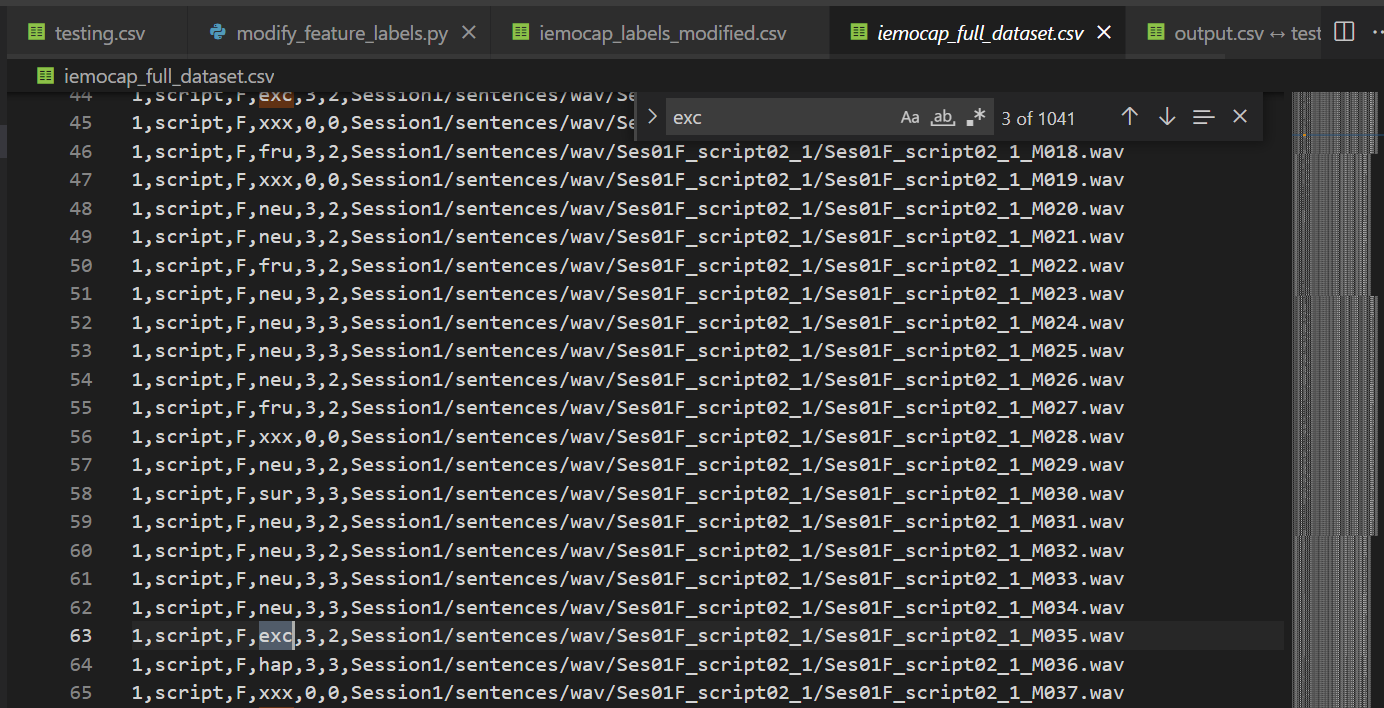

After the modification, all of them are replaced by hap

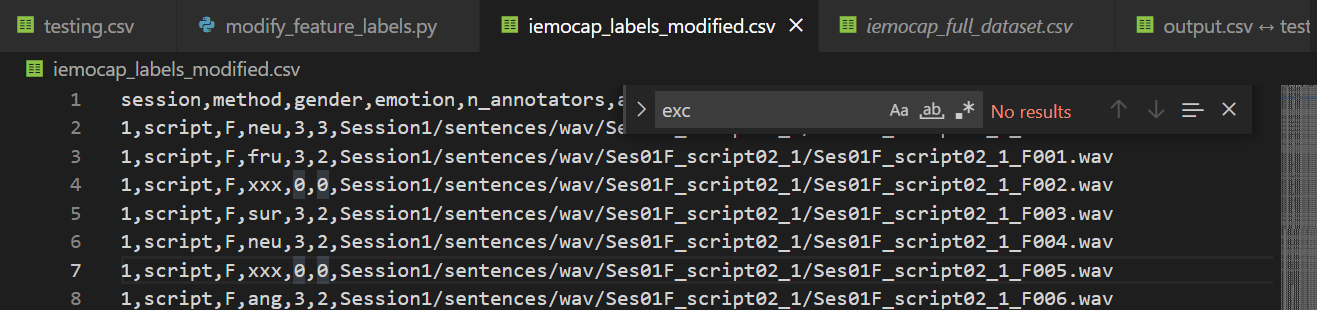

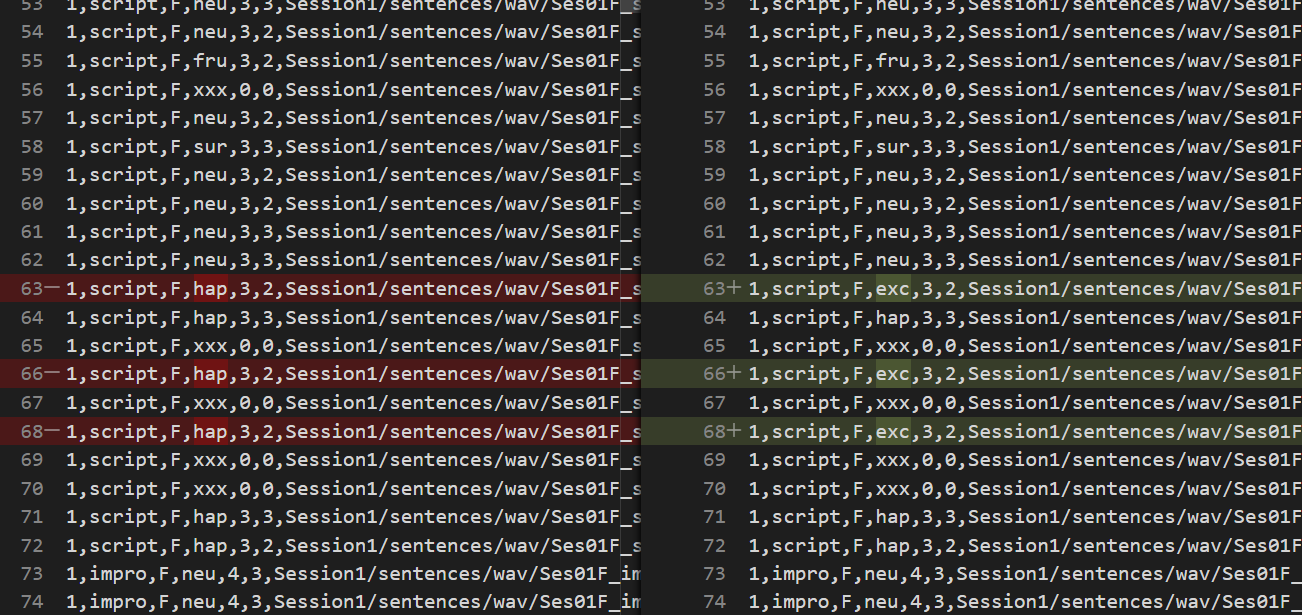

Mounting GD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !mkdir -p /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2")

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data

/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data


In [ ]:
!ls

IEMOCAP_full_release  iemocap_labels_modified.csv  IEMOCAP.zip


In [ ]:
# !unzip IEMOCAP.zip

Streaming output truncated to the last 5000 lines.
  inflating: IEMOCAP_full_release/Session5/sentences/MOCAP_head/Ses05M_impro04/Ses05M_impro04_M001.txt  
  inflating: IEMOCAP_full_release/Session5/sentences/MOCAP_head/Ses05M_impro04/Ses05M_impro04_M002.txt  
  inflating: IEMOCAP_full_release/Session5/sentences/MOCAP_head/Ses05M_impro04/Ses05M_impro04_M003.txt  
  inflating: IEMOCAP_full_release/Session5/sentences/MOCAP_head/Ses05M_impro04/Ses05M_impro04_M004.txt  
  inflating: IEMOCAP_full_release/Session5/sentences/MOCAP_head/Ses05M_impro04/Ses05M_impro04_M005.txt  
  inflating: IEMOCAP_full_release/Session5/sentences/MOCAP_head/Ses05M_impro04/Ses05M_impro04_M006.txt  
  inflating: IEMOCAP_full_release/Session5/sentences/MOCAP_head/Ses05M_impro04/Ses05M_impro04_M007.txt  
  inflating: IEMOCAP_full_release/Session5/sentences/MOCAP_head/Ses05M_impro04/Ses05M_impro04_M008.txt  
  inflating: IEMOCAP_full_release/Session5/sentences/MOCAP_head/Ses05M_impro04/Ses05M_impro04_M009.txt  
  in

In [ ]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization,GlobalMaxPool2D
from tensorflow import keras

Modified labels


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/iemocap_labels_modified.csv')# Create a list of the class labels
labels = list(df['emotion'].unique())
labels

['neu', 'fru', 'xxx', 'sur', 'ang', 'hap', 'sad', 'oth', 'fea', 'dis']

Vizualizing MFCCs and wave 

/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/IEMOCAP_full_release


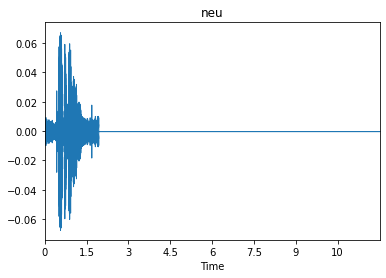

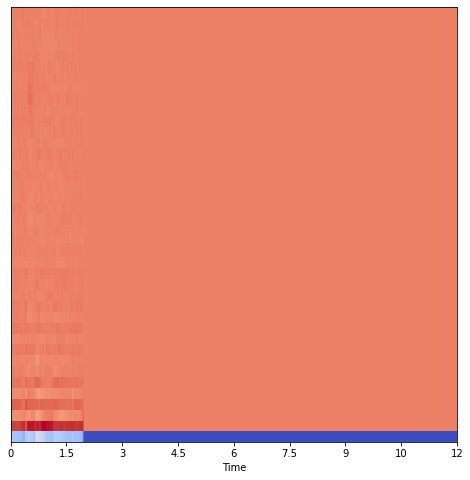

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/IEMOCAP_full_release
data, sr = librosa.load(df['path'][10])
sr
import librosa.display
plt.title(df['emotion'][0])
librosa.display.waveplot(data, sr= sr)
mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc = 40)
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [ ]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return mfccs

Trimming/padding audio files to 12 seconds

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/IEMOCAP_full_release

/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/IEMOCAP_full_release


In [ ]:
!pip install simpleaudio
!pip install pydub

     |████████████████████████████████| 2.0 MB 14.6 MB/s 
  Created wheel for simpleaudio: filename=simpleaudio-1.0.4-cp37-cp37m-linux_x86_64.whl size=2065967 sha256=c09da96bc20373f00cc4eeaa03ae332d85c821d8408d76d7417d087a6186c2fe
  Stored in directory: /root/.cache/pip/wheels/9a/d6/39/e26b6f988cc5acd1fba2c1b18f0debe27bdee3e1e53f4c93f9
Successfully built simpleaudio


#An attempt to find out the max duration among all audio files


In [ ]:
from pydub import AudioSegment
from pydub.playback import play
import simpleaudio as sa
max_dur = 0

for i in range(0,7):
  audio = AudioSegment.from_file('Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F00'+str(i)+'.wav')
  len=audio.duration_seconds
  print(len)
  if(len>max_dur):
    max_dur = len
# print(max_dur)

11.9999375
11.999875
11.9999375
11.999875
11.999875
11.9999375
11.999875


In [ ]:
df.shape[0]

10039

In [ ]:
real_max_duration = 0
for i in range(df.shape[0]):
  audio = AudioSegment.from_file(df['path'][i])
  duration = audio.duration_seconds
  if(duration>real_max_duration):
    real_max_duration = duration
print(real_max_duration)
  

34.13875


##Trim and fill

In [ ]:
from pydub import AudioSegment
from pydub.playback import play
import simpleaudio as sa
max_duration = 12
for i in range(df.shape[0]):
  audio = AudioSegment.from_file(df['path'][i])
  duration = audio.duration_seconds
  if(duration<max_duration):
    diff = max_duration - duration 
    diff*=1000
    diff = AudioSegment.silent(duration=diff) 
    audio+=diff
  elif(duration>max_duration):
    temp = max_duration*1000
    audio = audio[:temp]
  audio.export(df['path'][i], format="wav")

Extracting features 🐾 ♿ 
Neutral, Happy, Sad, Angry

In [ ]:
features = []
for i in range(df.shape[0]):
  if(df['emotion'][i]=="neu" or df['emotion'][i]=="hap" or df['emotion'][i]=="sad" or df['emotion'][i]=="ang"):
    class_label = df['emotion'][i]
    data = extract_features(df['path'][i])
    features.append([data,class_label])
  else: continue
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
featuresdf.to_csv('features.csv')
!cp features.csv "/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/IEMOCAP_full_release"
featuresdf.head()

cp: 'features.csv' and '/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/IEMOCAP_full_release/features.csv' are the same file


,feature,class_label
0,"[[-433.09747, -418.0225, -420.61838, -440.2444...",neu
1,"[[-412.2904, -412.0632, -424.42245, -437.68002...",neu
2,"[[-384.94653, -385.303, -403.36713, -417.61145...",ang
3,"[[-337.66733, -332.22464, -323.70685, -330.038...",ang
4,"[[-429.57663, -421.7656, -427.78027, -434.1675...",neu


Modification: convert feature column to numpy array


In [ ]:
import ast
featuresdf['feature'] = featuresdf['feature'].apply(lambda x: np.array(x))

Instead of re-computing the MFCCs, load it 

In [ ]:
# featuresss = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/IEMOCAP_full_release/features.csv")
# featuresss['feature'] = featuresss['feature'].apply(lambda x: np.array(ast.literal_eval(x))) 


In [ ]:
featuresdf.head()

,feature,class_label
0,"[[-433.09747, -418.0225, -420.61838, -440.2444...",neu
1,"[[-412.2904, -412.0632, -424.42245, -437.68002...",neu
2,"[[-384.94653, -385.303, -403.36713, -417.61145...",ang
3,"[[-337.66733, -332.22464, -323.70685, -330.038...",ang
4,"[[-429.57663, -421.7656, -427.78027, -434.1675...",neu


In [ ]:
del featuresdf['Unnamed: 0']
featuresdf.head()

,feature,class_label
0,[[-4.3309747e+02 -4.1802249e+02 -4.2061838e+02...,neu
1,[[-4.1229041e+02 -4.1206320e+02 -4.2442245e+02...,neu
2,[[-3.8494653e+02 -3.8530301e+02 -4.0336713e+02...,ang
3,[[-3.3766733e+02 -3.3222461e+02 -3.2370685e+02...,ang
4,[[-4.2957663e+02 -4.2176559e+02 -4.2778030e+02...,neu


In [ ]:
featuresdf.head()

,feature,class_label
0,[[-4.3309747e+02 -4.1802249e+02 -4.2061838e+02...,neu
1,[[-4.1229041e+02 -4.1206320e+02 -4.2442245e+02...,neu
2,[[-3.8494653e+02 -3.8530301e+02 -4.0336713e+02...,ang
3,[[-3.3766733e+02 -3.3222461e+02 -3.2370685e+02...,ang
4,[[-4.2957663e+02 -4.2176559e+02 -4.2778030e+02...,neu


In [ ]:
temp = featuresdf['class_label'].unique()
temp

array(['neu', 'ang', 'hap', 'sad'], dtype=object)

Features to numpy arrays


In [ ]:
featuresdf['feature'][0]

'[[-4.3309747e+02 -4.1802249e+02 -4.2061838e+02 ... -7.9299658e+02\n  -7.9299658e+02 -7.9299658e+02]\n [ 1.2442707e+02  1.3584601e+02  1.3930933e+02 ...  0.0000000e+00\n   0.0000000e+00  0.0000000e+00]\n [-5.1246758e+01 -5.1241653e+01 -4.7852119e+01 ...  0.0000000e+00\n   0.0000000e+00  0.0000000e+00]\n ...\n [ 3.1390417e-01  1.5148429e+00  6.2558353e-01 ...  0.0000000e+00\n   0.0000000e+00  0.0000000e+00]\n [ 5.4866214e+00  2.0440426e+00  5.9164059e-01 ...  0.0000000e+00\n   0.0000000e+00  0.0000000e+00]\n [ 1.7825859e+00 -3.4398470e+00 -4.5901203e+00 ...  0.0000000e+00\n   0.0000000e+00  0.0000000e+00]]'

In [ ]:
features_temp = featuresdf['feature']
X = [l.tolist() for l in features_temp]
X = np.array(X)
X.shape

(5531, 40, 517)

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [ ]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)
# x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)
x_train.shape, x_test.shape

((4424, 40, 517), (1107, 40, 517))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2, random_state=127)
# x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2, random_state=127)
x_train.shape, x_val.shape

((3539, 40, 517), (885, 40, 517))

In [ ]:
emotion_labels = yy.shape[1]